In [1]:
import math
import numpy as np
import os
from collections import defaultdict
import scipy.stats as stats
import matplotlib.pyplot as plt
import random as nd
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
class Data :
    def __init__(self, inputfile) :
        self.data = self.construct_array(inputfile)
        self.num_games = self.data[-1][0]

    def construct_array (self, inputfile) :
        data = open(inputfile, 'r')
        ndtype = [('game-number', 'int'),
                  ('clock', 'int'),
                  ('high-payoff-location', 'a10'),
                  ('player', 'a5'),
                  ('xcor', 'f8'),
                  ('ycor', 'f8'),
                  ('heading', 'f8'),
                  ('points-earned', 'int'),
                  ('noise', 'f8')]
        strucArray = genfromtxt(data, dtype = ndtype, delimiter = ',')
        return strucArray

    def get_data (self) :
        return self.data

In [3]:
def get_blue_data (data) :
    b = data['player'] == 'host'
    return data[b]

def get_red_data (data) :
    b = data['player'] == 'other'
    return data[b]

def get_game_data (data, game_number) :
    b = data['gamenumber'] == game_number
    return data[b]

In [4]:
def get_outcome_seq(conflict_level, who, cond) :
    max_points = 4 if conflict_level == 'high' else 2
    big_list = []
    for r,d,f in os.walk('../data/{0}_{1}_{2}/completed'.format(conflict_level, who, cond)):
        for files in f:
            if files.startswith('game_'):
                ts = []
                destination = r + '/' + files
                d = Data(destination).get_data()
                num_games = d[-1][0]
                red_data, blue_data = get_red_data(d), get_blue_data(d)
                red_points, blue_points = 0, 0                                                                                  
                for i in range(1,num_games+1) :
                    g = get_game_data(d,i)
                    if get_red_data(g)[0][-2] == get_red_data(g)[-1][-2] - max_points :
                        ts.append('R')
                    elif get_blue_data(g)[0][-2] == get_blue_data(g)[-1][-2] - max_points :
                        ts.append('B')
                    else :
                        ts.append('T')
                big_list.append(ts)
    return big_list

In [8]:
h_human_dyn = get_outcome_seq("high", "human", "dynamic")
h_human_rea = get_outcome_seq("high", "human", "reactive")
h_human_bal = get_outcome_seq("high", "human", "ballistic")
l_human_dyn = get_outcome_seq("low", "human", "dynamic")
l_human_rea = get_outcome_seq("low", "human", "reactive")
l_human_bal = get_outcome_seq("low", "human", "ballistic")

In [9]:
print "1 vs. 4 human dynamic:\t", len(h_human_dyn)
print "1 vs. 4 human reactive:\t", len(h_human_rea)
print "1 vs. 4 human ballistic:", len(h_human_bal)
print "1 vs. 2 human dynamic:\t", len(l_human_dyn)
print "1 vs. 2 human reactive:\t", len(l_human_rea)
print "1 vs. 2 human ballistic:", len(l_human_bal)

1 vs. 4 human dynamic:	69
1 vs. 4 human reactive:	57
1 vs. 4 human ballistic: 56
1 vs. 2 human dynamic:	46
1 vs. 2 human reactive:	57
1 vs. 2 human ballistic: 52


In [5]:
h_model_dyn = get_outcome_seq("high", "model", "dynamic")
#h_model_rea = get_outcome_seq("high", "model", "reactive")
#h_model_bal = get_outcome_seq("high", "model", "ballistic")
#l_model_dyn = get_outcome_seq("low", "model", "dynamic")
#l_model_rea = get_outcome_seq("low", "model", "reactive")
#l_model_bal = get_outcome_seq("low", "model", "ballistic")

In [6]:
print "1 vs. 4 model dynamic:\t", len(h_model_dyn)
#print "1 vs. 4 model reactive:\t", len(h_model_rea)
#print "1 vs. 4 model ballistic:", len(h_model_bal)
#print "1 vs. 2 model dynamic:\t", len(l_model_dyn)
#print "1 vs. 2 model reactive:\t", len(l_model_rea)
#print "1 vs. 2 model ballistic:", len(l_model_bal)

1 vs. 4 model dynamic:	50


get_surprise_ts first builds up a conditional probability distribution giving the likelihood of observing one outcome given the previous m outcomes. Once we have this distribution, it computes Shannon's surprisal for each round of the game

In [5]:
def get_surprise_ts (ts, num_back = 2) :
    d = defaultdict(lambda: defaultdict(int))
    surp = []
    # Build conditional distribution
    for i in range(len(ts) - num_back - 1) :
        substring = ts[i:i+num_back + 1]
        d[''.join(substring[:num_back])][substring[-1]] += 1
    # Compute surprisal (-log(p)) for each time step
    for i in range(len(ts) - num_back - 1) :
        substring = ts[i:i+num_back + 1]
        relevant_d = d[''.join(substring[:num_back])]
        # Add 1/k for virtual counts
        surp.append(-np.log2((relevant_d[substring[-1]] + 1/float(3))/float((sum(relevant_d.values()) + 1))))
    return surp

## S5 Fig

In [6]:
def plot_sequence (seq, title = "") :
    new_l1 = [t for t in seq]
    for i,s in enumerate(seq):
        if s == 'T' :
            new_l1[i]='black'
        elif s == 'B' :
            new_l1[i] = 'blue'
        elif s == 'R' :
            new_l1[i] = 'red'
    plt.bar(range(len(seq)), np.ones(len(seq)), width = 1, color = new_l1)
    plt.title(title)
    plt.xlabel("Game Number")
    frame1 = plt.gca()
    frame1.axes.get_yaxis().set_visible(False)
    matplotlib.rcParams.update({'font.size': 12})

# For all Dyads in a condition

In [21]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 16)

index = 0

for i in range (50):
    
    out_seq = get_outcome_seq("high", "model", "dynamic")[i]

    plt.subplot(321)
    plot_sequence(out_seq, title = "Dyad "+ str(i+1) + " outcomes")
    plt.xlim([0, 100])
    num_back = 2

    matplotlib.rcParams.update({'font.size': 12})
    plt.subplot(323)
    plot(get_surprise_ts(out_seq))
    plt.ylim([0, 3.5])
    plt.ylabel("Surprisal(bits)")
    plt.xlim([0, 100])
    plt.xlabel("Rounds")

    plt.subplot(325)
    plt.hist(get_surprise_ts(out_seq), range = (0, 3), normed=True)
    plt.ylim([0,4])
    plt.xlabel("Surprisal (bits)")
    plt.ylabel("Frequency")

    subplots_adjust(wspace=0.1, hspace=0.25)
    plt.savefig("../data/figures/Outcomes_Dyad"+ str(i+1) + ".png")
    plt.gcf().clear()


# For just one

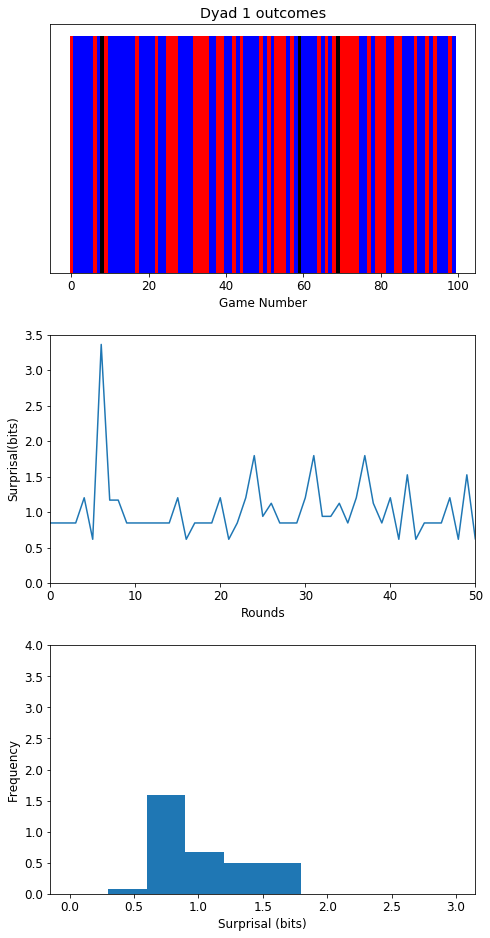

In [10]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 16)

## asdf 
index = 1
out_seq = get_outcome_seq("high", "model", "ballistic")[index]

plt.subplot(321)
plot_sequence(out_seq, title = "Dyad "+ str(index) + " outcomes")

num_back = 2

matplotlib.rcParams.update({'font.size': 12})
plt.subplot(323)
plot(get_surprise_ts(out_seq))
plt.ylim([0, 3.5])
plt.ylabel("Surprisal(bits)")
plt.xlim([0, 50])
plt.xlabel("Rounds")

plt.subplot(325)
plt.hist(get_surprise_ts(out_seq), range = (0, 3), normed=True)
plt.ylim([0,4])
plt.xlabel("Surprisal (bits)")
plt.ylabel("Frequency")

subplots_adjust(wspace=0.1, hspace=0.25)
plt.savefig("../data/figures/S5_Fig.tiff")